<h1>Оценка и анализ моделей</h1>

Первоначально оценим  метрики моделей, чтобы понять какую из них лучше всего брать для обучения

Из моделей рассматриваются:
- yolo v8 nano
- yolo v8 small
- yolo v11 nano

>Блокнот используется только для оценки, все рассчеты и вспомогательные функции описаны  .py файлах

In [16]:
%matplotlib inline

In [2]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Лямбда функция для помощи датафрейму
data_metrics = lambda model_metrics:{
    'mAP50': float(model_metrics.box.map50),
    'mAP50-95': float(model_metrics.box.map),
    'mAP75': float(model_metrics.box.map75),
    'Precision': float(model_metrics.box.mp),
    'Recall': float(model_metrics.box.mr),
}


In [4]:
def plot_metrics(data):
    # Создаем DataFrame
    df = pd.DataFrame([data])

    # Создаем один график с несколькими гистограммами
    fig, ax = plt.subplots(figsize=(6, 4))

    # Преобразуем данные для построения
    metrics = list(data.keys())
    values = list(data.values())

    # Создаем столбчатую диаграмму (похожа на гистограмму для одного значения)
    bars = ax.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'violet'], alpha=0.7)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    # Настройки графика
    ax.set_ylabel('Значения метрик')
    ax.set_xlabel('Метрики')
    ax.set_title('Финальные метрики модели')
    ax.set_ylim(0, 1.0)  # Так как все метрики в диапазоне 0-1
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Улучшаем расположение
    plt.tight_layout()
    plt.show()

>Для теста было решено взять 100 фреймов из виде о разметить на них людей, чтобы можно было оценить модель на том же видео что и распознаются люди

In [5]:
model8n = YOLO("yolov8n.pt")
metrics8n = model8n.val(data="videos/test_dataset/data.yaml",
                    split="test")

model8s = YOLO("yolov8s.pt")
metrics8s = model8s.val(data="videos/test_dataset/data.yaml",
                    split="test")

model11n = YOLO("yolo11n.pt")
metrics11n = model11n.val(data="videos/test_dataset/data.yaml",
                    split="test")


Ultralytics 8.3.220  Python-3.11.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
val: Fast image access  (ping: 0.20.1 ms, read: 234.048.1 MB/s, size: 83.5 KB)
val: Scanning C:\Users\User\PycharmProjects\test_work\videos\test_dataset\test\labels... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 2.0Kit/s 0.1s
val: New cache created: C:\Users\User\PycharmProjects\test_work\videos\test_dataset\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.3s
                   all        100       1547      0.697       0.55      0.629      0.227
                person        100       1547      0.697       0.55      0.629      0.227
Speed: 2.2ms preprocess, 4.5ms inference, 0.0ms loss, 7.2ms postprocess per image
Results saved to C:\Users\User\PycharmProjects\test_work\runs\detect\val11
Ultralytics

In [6]:
data8n = data_metrics(metrics8n)
data8s = data_metrics(metrics8s)
data11n = data_metrics(metrics11n)

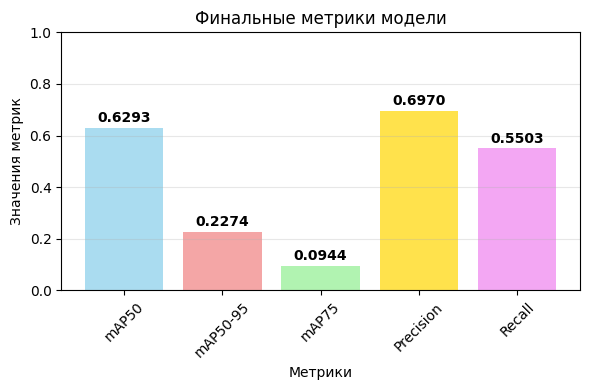

In [17]:
plot_metrics(data8n)

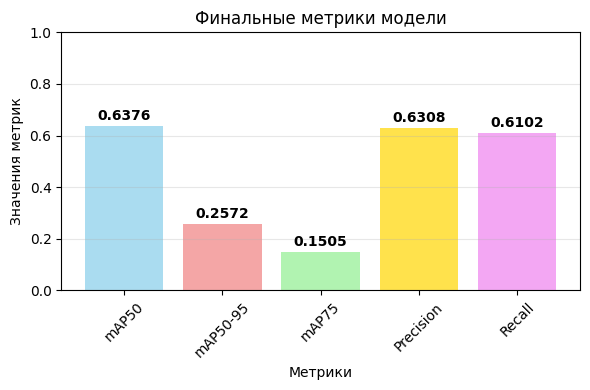

In [18]:
plot_metrics(data8s)

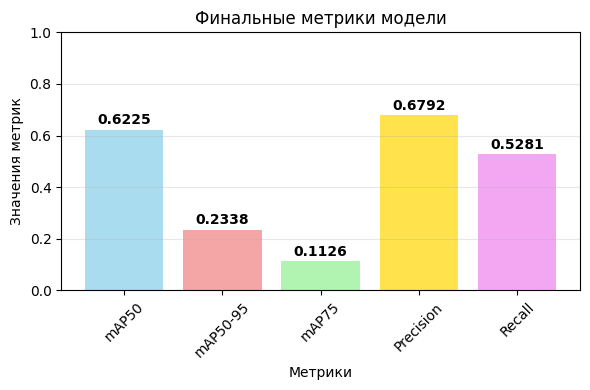

In [19]:
plot_metrics(data11n)

Как видно из метрик, лучша необученная модель - v8 small. Для лучших резутьтаов предлагаю дообучить ее на этом датасете


<h2>Эксперемент 1 - fine tuning модели под людей</h2
>

https://www.kaggle.com/datasets/luiscrmartins/surveillance-images-for-person-detection/data

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("luiscrmartins/surveillance-images-for-person-detection")


path += '/person-3'
print("Path to dataset files:", path)

C:\Users\User\PycharmProjects\test_work\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\luiscrmartins\surveillance-images-for-person-detection\versions\1/person-3


>Для удобства в ручную объеденим датасет, чтобы были все части выборки

Обучим модель в файле train.py и сравним результаты с заранее обученными моделями


In [20]:
model8s_train = YOLO("runs/detect/yolov8n_train14/weights/best.pt")
metrics8s_t = model8s_train.val(data="videos/test_dataset/data.yaml",
                    split="test")

Ultralytics 8.3.220  Python-3.11.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1699.4453.6 MB/s, size: 86.6 KB)
val: Scanning C:\Users\User\PycharmProjects\test_work\videos\test_dataset\test\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 99.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 4.1it/s 1.7s0.2ss
                   all        100       1547      0.534      0.393      0.427      0.143
Speed: 2.4ms preprocess, 8.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to C:\Users\User\PycharmProjects\test_work\runs\detect\val15


Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


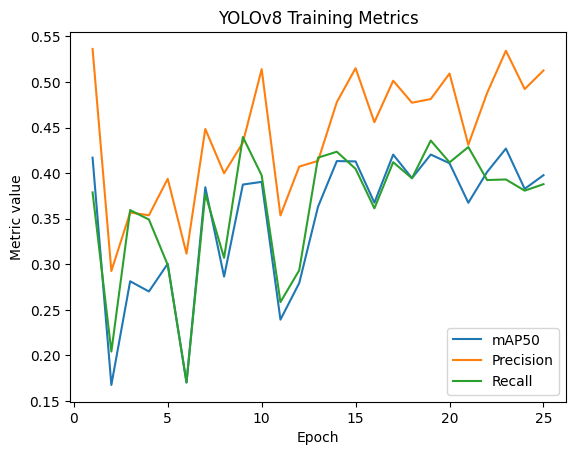

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Путь к файлу метрик
metrics_path = "runs/detect/yolov8n_train14/results.csv"

# Загружаем метрики
df = pd.read_csv(metrics_path)

# Смотрим, какие столбцы есть
print(df.columns)

# Пример построения графика изменения mAP
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50")
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Metric value")
plt.legend()
plt.title("YOLOv8 Training Metrics")
plt.show()

Оценим улучшение точности теперь уже обученной модели

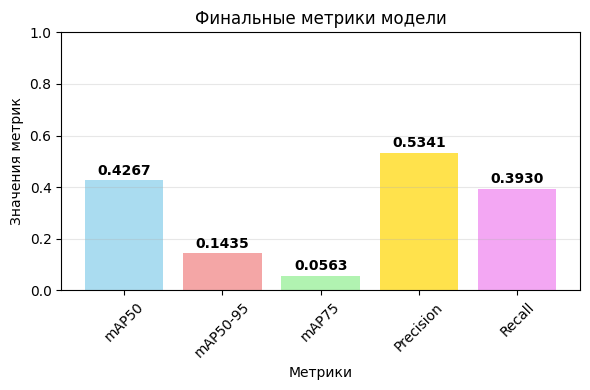

In [22]:
data8s_t = data_metrics(metrics8s_t)
plot_metrics(data8s_t)

В ходе эксперимента столкнулись с понижением качества модели.
Пока лучшей моделью определяющей людей на видео остается **yolo v8 small**

<h2>Эксперимент 2 - понижение достоверности определения</h2>

Ultralytics 8.3.220  Python-3.11.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1648.1417.3 MB/s, size: 88.4 KB)
val: Scanning C:\Users\User\PycharmProjects\test_work\videos\test_dataset\test\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.5it/s 2.0s0.3ss
                   all        100       1547       0.63      0.611      0.648      0.292
                person        100       1547       0.63      0.611      0.648      0.292
Speed: 3.1ms preprocess, 8.4ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to C:\Users\User\PycharmProjects\test_work\runs\detect\val17


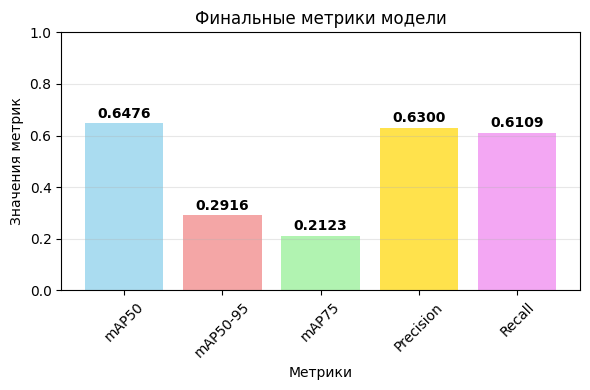

In [25]:
model8s = YOLO("yolov8s.pt")
metrics8s = model8s.val(data="videos/test_dataset/data.yaml",
                    split="test",
                    conf=0.2)
data8s = data_metrics(metrics8s)
plot_metrics(data8s)

Ultralytics 8.3.220  Python-3.11.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1596.7342.1 MB/s, size: 84.3 KB)
val: Scanning C:\Users\User\PycharmProjects\test_work\videos\test_dataset\test\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.9it/s 1.8s0.2s
                   all        100       1547      0.684      0.562      0.639      0.297
                person        100       1547      0.684      0.562      0.639      0.297
Speed: 2.4ms preprocess, 7.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to C:\Users\User\PycharmProjects\test_work\runs\detect\val19


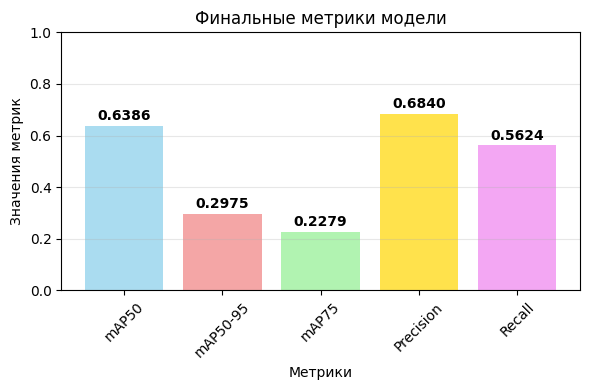

In [27]:
model8s = YOLO("yolov8s.pt")
metrics8s = model8s.val(data="videos/test_dataset/data.yaml",
                    split="test",
                    conf=0.3)
data8s = data_metrics(metrics8s)
plot_metrics(data8s)

Ultralytics 8.3.220  Python-3.11.0 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1428.9384.4 MB/s, size: 81.9 KB)
val: Scanning C:\Users\User\PycharmProjects\test_work\videos\test_dataset\test\labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 99.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 4.3it/s 1.6s0.2ss
                   all        100       1547      0.735      0.262      0.502      0.212
Speed: 2.8ms preprocess, 8.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to C:\Users\User\PycharmProjects\test_work\runs\detect\val22


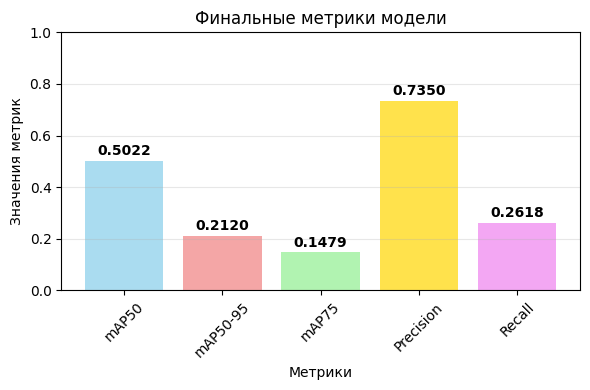

In [30]:
model8s_train = YOLO("runs/detect/yolov8n_train14/weights/best.pt")
metrics8s_t = model8s_train.val(data="videos/test_dataset/data.yaml",
                    split="test",
                    conf=0.3)
data8s = data_metrics(metrics8s_t)
plot_metrics(data8s)


Метрика	    Предобученная модель	Модель со скачанными весами

- Precision (P)         0.735	        0.684
- Recall (R)	        0.262	        0.562
- mAP@50	            0.502	        0.639
- mAP@50-95	            0.2120	        0.297

1. Предобученная модель лучше подходит для задач, где критически важна минимизация ложных срабатываний

2. Модель со скачанными весами демонстрирует более сбалансированную производительность и лучше справляется с обнаружением объектов в различных условиях

